Pretty front-end for the simulation and the run-result's analysis.

Imports the functions from the source-files and persists the outputs for easier perusing.

In [1]:
# We want to reload all modules before execution, each time, as we do not care about performance
# but easy development and we will be changing the modules a ton:
%load_ext autoreload
%autoreload 2

In [2]:
import operator
import functools
import numpy as np
import matplotlib.pyplot as plt
from strategy_simulation import Simulation, SimulationOptions

In [3]:
sim = Simulation()

Loaded 220 stocks from prices.
55 stocks were rejected for reason of having less than 5000 entries.
After filtering out 0 rows with weird date formats, 10552 rows remain.
After removal of discontinuous stock price lists was skipped, 165 stocks are left.



## Analyse the missing fields in the prices

In [4]:
is_na_df = sim.prices.isna()
is_na_matrix = is_na_df.values

In [5]:
# Find the number of status switches for each stock, where a status switch is when data becomes available 
# or ceases to be available:
status_switch = is_na_matrix[1:, :] != is_na_matrix[:-1, :]

In [6]:
# Stock-wise number of status switches over the history:
status_switch.sum(axis=0)

array([375, 376, 376, 376, 376, 376, 346, 376, 358, 376, 376, 376, 376,
       376, 376, 376, 358, 375, 375, 375, 376, 376, 376, 376, 376, 375,
       376, 376, 376, 375, 376, 376, 376, 376, 376, 375, 376, 376, 376,
       358, 358, 376, 376, 376, 376, 376, 378, 376, 358, 376, 376, 376,
       376, 375, 376, 313, 376, 358, 376, 376, 376, 376, 362, 358, 376,
       313, 375, 375, 358, 376, 376, 376, 376, 376, 376, 375, 376, 375,
       358, 376, 376, 376, 375, 376, 376, 376, 366, 376, 375, 375, 376,
       375, 375, 368, 376, 376, 376, 375, 375, 358, 376, 375, 376, 376,
       376, 375, 370, 364, 375, 374, 364, 376, 376, 376, 375, 358, 358,
       376, 313, 376, 376, 375, 376, 375, 362, 376, 375, 375, 376, 376,
       358, 376, 376, 364, 358, 362, 376, 375, 375, 375, 376, 376, 375,
       375, 362, 376, 376, 376, 376, 338, 376, 376, 375, 376, 376, 376,
       376, 375, 375, 375, 376, 375, 376, 358, 358])

**Learning**: There is a fairly consistent number of switches, which seems to indicate that the data has a common pattern of availability.

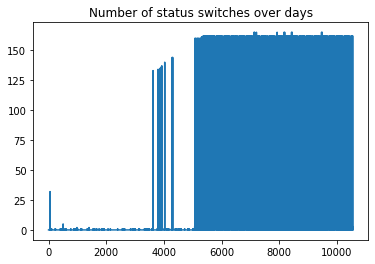

In [7]:
plt.plot(status_switch.sum(axis=1))
plt.title('Number of status switches over days')
plt.show()

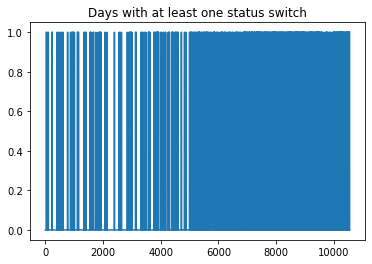

In [8]:
plt.plot(status_switch.sum(axis=1) > 0)
plt.title('Days with at least one status switch')
plt.show()

[]

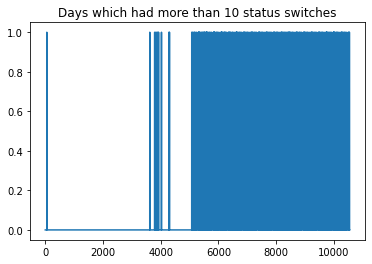

In [9]:
plt.plot(status_switch.sum(axis=1) > 10)
plt.title('Days which had more than 10 status switches')
plt.plot()

[]

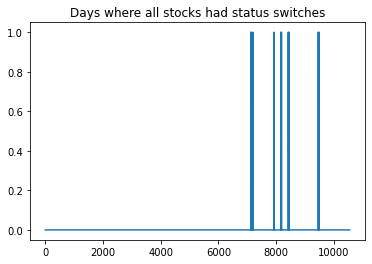

In [10]:
plt.plot(status_switch.sum(axis=1) == len(sim.prices.columns))
plt.title('Days where all stocks had status switches')
plt.plot()

**Learning**: Since about 2003 (index 6000'ish), there were fewer status switches, but if there some, they affect all stocks. Seems to be the missing data is training pauses.

In [11]:
# At which days did the training stops after happen?
sim.prices.index[6001:][status_switch[6000:, :].sum(axis=1) == len(sim.prices.columns)]

Index(['2007-11-23', '2007-12-25', '2008-03-21', '2010-12-24', '2011-11-24',
       '2011-12-26', '2012-11-23', '2012-12-25', '2016-11-24', '2016-12-26'],
      dtype='object', name='Date')

In [12]:
# We can now go through each stock in line and pairwise compare the indices of status switches.
# This should give us an idea of the length of the stopped data.
stock_missing_data_lengths = {}
for k, stock in enumerate(sim.prices):
    # If a stock starts with a nan, we need an offset for the switch-difference:
    stock_starts_with_nan = np.isnan(sim.prices[stock].iloc[0])
    
    # Now, there could also be a trailing nan, which means that we had the bad luck
    # of catching a stock right in the middle of a trading pause. Taking a difference
    # There becomes impossible, so we will end the loop earlier then:
    stock_ends_with_nan = np.isnan(sim.prices[stock].iloc[-1])
    
    # Get the switching dates and convert them to datetime (two lines, for readability ;) ):
    switching_dates = sim.prices.index[1:][status_switch[:, k]].values
    switching_dates = np.asarray([np.datetime64(d) for d in switching_dates])
    
    # Compare the date-pairs:
    date_differences = [
        ((switching_dates[i + 1] - switching_dates[i]) / np.timedelta64(1, 'D')).astype(int) 
        for i in range(
            int(stock_starts_with_nan), 
            len(switching_dates) - 1 + int(stock_starts_with_nan) - int(stock_ends_with_nan), 
            2
        )
    ]

    stock_missing_data_lengths[stock] = date_differences

In [13]:
all_missing_data_lengths = functools.reduce(operator.iconcat, [v for k, v in stock_missing_data_lengths.items()], [])
np.unique(all_missing_data_lengths, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  8, 10]),
 array([24603,   180,  5533,    27,     6,   171,     3,     3]))

All missing data slots are not longer than a week, and 70+% are just one day.

# Dry-run of the simulation

In [14]:
sim.run(random_subset_size=10)

Finished calculating the yearly sigmas.


/home/notger-heinz/projects_and_analysis/black_swan_strategy/black_scholes_model.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.log(s0 / k) + (r + (sigma ** 2) / 2) * t) / (sigma * np.sqrt(t))
/home/notger-heinz/projects_and_analysis/black_swan_strategy/strategy_simulation.py:199: RuntimeWarning: invalid value encountered in double_scalars
  return (max(0, strike_price - prices[payout_index]) - option_price) / option_price


,XEL_prices,BEN_prices,ATO_prices,NEE_prices,TSCO_prices,CCI_prices,XLNX_prices,WMB_prices,TJX_prices,NTAP_prices
Date,,,,,,,,,,
1979-12-31,6.908105e-310,1.000000,NaN,1.013699,0.992509,0.983529,0.992311,NaN,1.013811,1.007753
1980-01-02,4.569654e-316,1.010274,NaN,1.017621,1.022936,0.969350,1.007378,NaN,1.015365,1.000568
1980-01-03,4.569654e-316,NaN,NaN,1.000000,1.002732,1.002933,0.982343,NaN,1.001376,1.009928
1980-01-04,4.569654e-316,NaN,1.003953,NaN,0.995868,0.999038,0.998734,NaN,1.032550,1.008663
1980-01-07,1.000000e+00,NaN,1.023438,1.000000,1.016760,1.027397,1.004970,NaN,0.990949,1.010915
...,...,...,...,...,...,...,...,...,...,...
2021-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


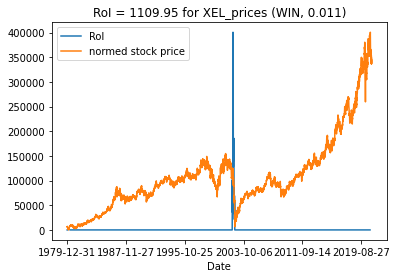

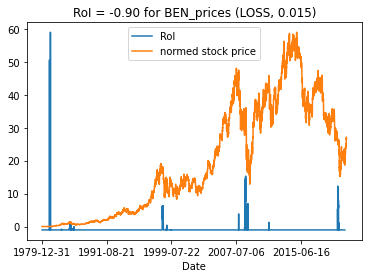

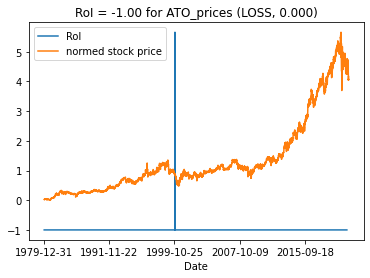

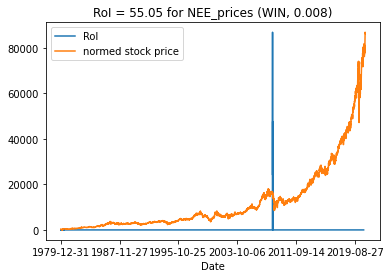

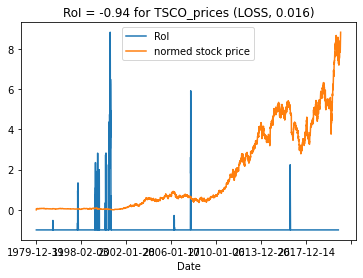

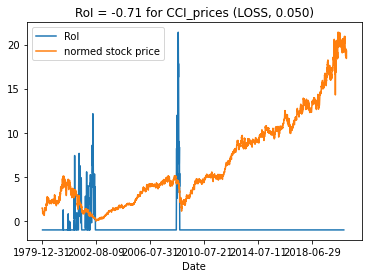

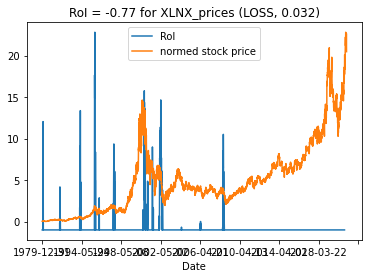

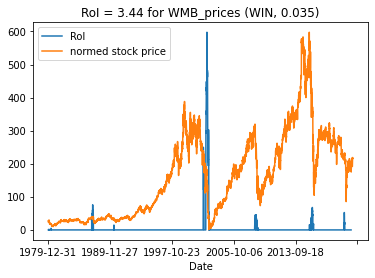

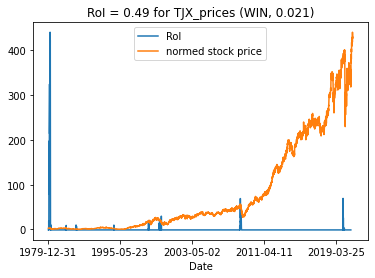

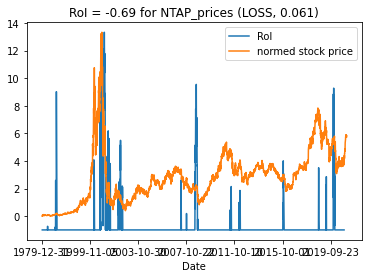

In [15]:
for stock in sim.payouts:
    payouts = sim.payouts[~sim.sigmas[stock].isna()][stock]
    normed_stock_prices = sim.prices[~sim.sigmas[stock].isna()][stock]
    normed_stock_prices -= normed_stock_prices.min()
    normed_stock_prices /= normed_stock_prices.max()
    normed_stock_prices *= payouts.max()
    tag = 'WIN' if payouts.mean() > 0 else 'LOSS'
    percentage_of_positive_days = (payouts > 0.0).sum() / len(payouts)
    
    fig = plt.subplots()
    payouts.plot()
    normed_stock_prices.plot()
    plt.title(f'RoI = {payouts.mean():.2f} for {stock} ({tag}, {percentage_of_positive_days:.3f})')
    plt.legend(['RoI', 'normed stock price'])

In [16]:
# RoI (in 1) per stock:
sim.payouts.mean()

XEL_prices     1109.950280
BEN_prices       -0.887616
ATO_prices       -0.986456
NEE_prices       55.049832
TSCO_prices      -0.916896
CCI_prices       -0.683439
XLNX_prices      -0.747087
WMB_prices        3.420543
TJX_prices        0.496649
NTAP_prices      -0.669390
dtype: float64

In [17]:
# Variation of RoI (in 1) = risk of picking only one stock:
sim.payouts.mean().std()

349.5299031109667

In [18]:
# Total RoI (in 1) over all stocks:
sim.payouts.mean().mean()

116.40264196254714

In [19]:
# Share of worthwhile days / share of loss days:
print('Share of winning days in %:')
for stock in sim.payouts:
    payouts = sim.payouts[~sim.sigmas[stock].isna()][stock]
    percentage_of_positive_days = (payouts > 0.0).sum() / len(payouts)
    print(f'{stock}: {percentage_of_positive_days * 100:.1f}')

Share of winning days in %:
XEL_prices: 1.1
BEN_prices: 1.5
ATO_prices: 0.0
NEE_prices: 0.8
TSCO_prices: 1.6
CCI_prices: 5.0
XLNX_prices: 3.2
WMB_prices: 3.5
TJX_prices: 2.1
NTAP_prices: 6.1


In [20]:
# Share of winning stocks:
print(f'{100 * (sim.payouts.mean() > 0).sum() / len(sim.payouts.columns)} % of stocks were winners.')

40.0 % of stocks were winners.
